# Example I: Tracking radar data

In this example notebook we are going to track rain-rates that we estimated from radar based refelectivities. The rain-rates is an example dataset from the CPOL radar archive that used to operate north of Darwin Australia. This example dataset has been provided by Valentin Louf from the Australian Bureau of Metorology.

A more detailed example of the application of the tracking algorithm can be found in [doi: 10.1002/qj.4360](https://rmets.onlinelibrary.wiley.com/doi/abs/10.1002/qj.4360)

Before we get started we import all modules that are needed to apply the tracking

In [1]:
%matplotlib inline
import os
from pathlib import Path
import pandas as pd
import xarray as xr
from tintx import RunDirectory, config
from IPython.display import HTML

In this example we want to apply the tracking algorithm only for a limited time period. Such time periods can be given as string or `datetime` objects. If defined as a string make sure they follow the [ISO 8061](https://en.wikipedia.org/wiki/ISO_8601) convention.

In [2]:
first = '2006-11-16 03:00' #Start-date
last = '2006-11-16 11:00' #End-date
data_files = Path("_static") / "data"

To apply the tracking we create an instance of the `RunDirectory` class. Normally we would have to create this instance with a `xarray.DataArray`. The `from_files` method is a convenience method that allows us to create this instance without opening a dataset. The method will open the data files and create an object. We we will have to provied are filename(s) or a list of files the name of the variable and if not according to cf conventions the names of the *longitude*, *latitude* and *time* dimensions:

In [3]:
RD = RunDirectory.from_files( data_files / "CPOL_radar.nc", "radar_estimated_rain_rate",
                             start=first, end=last, use_cftime=True, x_coord="longitude", y_coord="latitude")

Additional keyword arguments can be added to the `xarray.open_mfdataset` method. In this example we used the `use_cftime` keyword to convert the time variable to cftime vectors.

### The tuning paramters
To apply the actual tracking algorithm we can use the `get_tracks` method. The algorithm can be tuned by passing the values for the tuning parameters. See also the [tuning parameter section](api.html#tracking-parameter-guide) of the docs

In [4]:
print(config.__doc__)


Tracking tuning parameters
--------------------------

The following parameter can be set to tune the cell tracking algorithm

* field_thresh : units of 'field' attribute, default: 32
    The threshold used for object detection. Detected objects are connected
    pixels above this threshold.
* iso_thresh : units of 'field' attribute, default: 4
    Used in isolated cell classification. Isolated cells must not be connected
    to any other cell by contiguous pixels above this threshold.
* iso_smooth : pixels, default: 4
    Gaussian smoothing parameter in peak detection preprocessing. See
    single_max in tint.objects.
* min_size : square kilometers, default: 8
    The minimum size threshold in pixels for an object to be detected.
* search_margin : meters, default: 250
    The radius of the search box around the predicted object center.
* flow_margin : meters, default: 750
    The margin size around the object extent on which to perform phase
    correlation.
* max_disparity : float, 

Apply the tracking with a rain-rate threshold of 0.001 and a minimum size of 4. The return value of the function will be the total number of individual storms identified by the alogorithm

In [5]:
num_cells = RD.get_tracks(field_thresh=0.001, min_size=4)
print(f"Number of storm cells found: {num_cells}")

Tracking:   0%|          | 0/48 [00:00<?, ?it/s]

Number of storm cells found: 114


### Accessing the track data
The actual tracking data is stored in mulit-index a [pandas.DataFrame](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.MultiIndex.html) and can be accessed via the `tracks` property:

In [6]:
RD.tracks

time   grid_x  grid_y       lon      lat  area  \
scan uid                                                                  
0    0    2006-11-16 03:00:00    6.308  45.731  129.8469 -12.5164    26   
     1    2006-11-16 03:00:00    2.034  51.655  129.7554 -12.3810    29   
     2    2006-11-16 03:00:00  101.636  50.909  132.0573 -12.4047    77   
     3    2006-11-16 03:00:00   74.889  49.667  131.4358 -12.4288     9   
     4    2006-11-16 03:00:00   90.400  52.533  131.7810 -12.3606    30   
...                       ...      ...     ...       ...      ...   ...   
46   113  2006-11-16 10:40:00   31.000  79.500  130.4244 -11.7539     6   
47   112  2006-11-16 10:50:00   89.000  15.167  131.7603 -13.2150    12   
     111  2006-11-16 10:50:00   37.586  79.034  130.5851 -11.7766    29   
     113  2006-11-16 10:50:00   30.800  79.600  130.4244 -11.7539     5   
48   111  2006-11-16 11:00:00   37.185  79.407  130.5622 -11.7766    27   

                max      mean  isolated  
scan uid                                 
0    0     1.451491  0.980084     False  
     1     1.398994  0.771455      True  
     2     5.279258  0.556644     False  
     3     1.249542  0.313930      True  
     4     3.560659  0.741776      True  
...             ...       ...       ...  
46   113   9.346570  2.270303      True  
47   112   0.227352  0.149808     False  
     111  14.703703  2.857256     False  
     113   3.873376  1.435547      True  
48   111  14.791470  2.616149      True  

[289 rows x 9 columns]

## Displaying the results
Let's do some visualisation and create an animation of the tracks. This can be done by calling the `animate` method.
**Note:** To convert possibel utc time strings to local time we can give a time shift (`dt`) in hours. The plot styling can be fine tuned by the `plot_style` key word

In [7]:
anim = RD.animate(dt=9.5, fps=2, plot_style=dict(resolution="10m", title="Rain-rate"))

The return value is a [matplotlib `FuncAnimation` Object](https://matplotlib.org/stable/api/_as_gen/matplotlib.animation.FuncAnimation.html). The animation can be save or displayed in a notbook:

In [8]:
HTML(anim.to_html5_video())

Animating:   0%|          | 0/48 [00:00<?, ?it/s]

It is also possible to save the animation to a file

```python
anim.save("cpol_tracking.gif", fps=3)
```

The traces of the tracks can also be plotted using the `plot_trajectories` method:

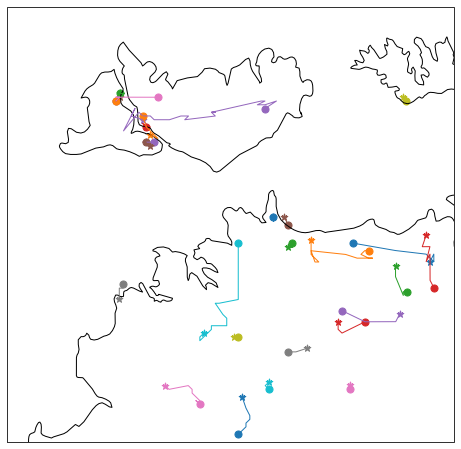

In [9]:
ax = RD.plot_trajectories()

### Saving the tracks for later analysis:
we can use pandas to save the track data and do a more in depth analysis on the storm systems later. The data can then also be loaded using pandas.

In [10]:
RD.tracks.to_hdf('/tmp/tint_tracks.h5', 'tracks')
table = pd.read_hdf('/tmp/tint_tracks.h5', 'tracks')
table.head()

/tmp/ipykernel_298087/3425257958.py:1: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block3_values] [items->Index(['time'], dtype='object')]

  RD.tracks.to_hdf('/tmp/tint_tracks.h5', 'tracks')


time   grid_x  grid_y       lon      lat  area  \
scan uid                                                                  
0    0    2006-11-16 03:00:00    6.308  45.731  129.8469 -12.5164    26   
     1    2006-11-16 03:00:00    2.034  51.655  129.7554 -12.3810    29   
     2    2006-11-16 03:00:00  101.636  50.909  132.0573 -12.4047    77   
     3    2006-11-16 03:00:00   74.889  49.667  131.4358 -12.4288     9   
     4    2006-11-16 03:00:00   90.400  52.533  131.7810 -12.3606    30   

               max      mean  isolated  
scan uid                                
0    0    1.451491  0.980084     False  
     1    1.398994  0.771455      True  
     2    5.279258  0.556644     False  
     3    1.249542  0.313930      True  
     4    3.560659  0.741776      True

# Example II: Tracking satellite data

## Applying the tracking with a dataset that has already been read

Sometimes data needs to be processed first. For example if derived variables like (density potential temperature) are applied to the tracking, or data needs to be remapped first. In this scenario you would create the netCDF dataset yourself, rather then letting the code load the data, and apply the tracking on the dataset. Below is an example:

In [11]:
# Read satellite based rainfall estimates and select a sub region.
files = [str(f) for f in data_files.rglob('CMORPH*.nc')]
# Select a box around the Maritime Continent
dset = xr.open_mfdataset(sorted(files), combine='by_coords').sel(lon=slice(100, 160), lat=slice(-13, 13))
dset

<xarray.Dataset>
Dimensions:      (time: 48, nv: 2, lat: 357, lon: 825)
Coordinates:
  * time         (time) datetime64[ns] 2020-01-25 ... 2020-01-25T23:30:00
  * lat          (lat) float64 -12.95 -12.88 -12.81 -12.73 ... 12.81 12.88 12.95
  * lon          (lon) float64 100.0 100.1 100.1 100.2 ... 159.8 159.9 160.0
Dimensions without coordinates: nv
Data variables:
    time_bounds  (time, nv) datetime64[ns] dask.array<chunksize=(2, 2), meta=np.ndarray>
    lat_bounds   (time, lat, nv) float64 dask.array<chunksize=(2, 357, 2), meta=np.ndarray>
    lon_bounds   (time, lon, nv) float64 dask.array<chunksize=(2, 825, 2), meta=np.ndarray>
    cmorph       (time, lat, lon) float32 dask.array<chunksize=(2, 357, 825), meta=np.ndarray>
Attributes: (12/57)
    ncei_template_version:      NCEI_NetCDF_Grid_template_V2.0
    title:                      NOAA Climate Data Record (CDR) of CPC Morphin...
    keywords:                   Precipitation, Satellite, High-Resolution, Gl...
    summary:                    The CMORPH CDR is a reprocessed and bias-corr...
    references:                 Xie, P., et al. (2017), Reprocessed, Bias-Cor...
    Conventions:                CF-1.6, ACDD-1.3
    ...                         ...
    geospatial_lat_resolution:  0.072771376
    geospatial_lat_units:       degrees_north
    geospatial_lon_min:         0.0
    geospatial_lon_max:         360.0
    geospatial_lon_resolution:  0.072756669
    geospatial_lon_units:       degrees_east

We can now simply create a `RunDicrectory` object by directly initialising the class: 

In [12]:
RD = RunDirectory("cmorph", dset.isel(time=slice(0, 20)))

Once the object has be created the cells can be tracked and plotted as bfore (with a little more tuning):

In [13]:
num_cells = RD.get_tracks(min_size=8,
                          field_thresh=3, 
                          iso_thresh=10,
                          iso_smoth=10,
                          search_margin=8750,
                          flow_margin=1750,
                          max_disparity=999,
                          max_flow_mag=5000,
                          max_shift_disp=1000,
                         )
print(f"Number of storm cells found: {num_cells}")

Tracking:   0%|          | 0/19 [00:00<?, ?it/s]

Number of storm cells found: 183


In [14]:
RD.tracks.head()

time   grid_x  grid_y       lon      lat  area   max  \
scan uid                                                                        
0    0    2020-01-25 01:00:00  623.304   2.087  145.3314 -12.8078    23  5.07   
     1    2020-01-25 01:00:00  819.826  13.765  159.6645 -11.9345   115  6.40   
     2    2020-01-25 01:00:00  620.889  22.111  145.1859 -11.3523     9  3.41   
     3    2020-01-25 01:00:00  617.827  29.442  144.9677 -10.8429    52  5.61   
     4    2020-01-25 01:00:00  594.500  48.400  143.2215  -9.4603    10  3.68   

              mean  isolated  
scan uid                      
0    0    4.811738     False  
     1    4.352870     False  
     2    3.383333     False  
     3    4.107116     False  
     4    3.420000     False

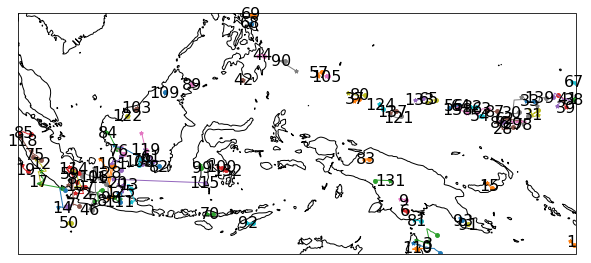

In [15]:
ax = RD.plot_trajectories(plot_style={"resolution": "10m", "ms": 15},
                          label=True,
                          mintrace=5
)